This notebook provides a visualisation of the raw data for the monoisotope, and shows the curve that was fitted to find the RT apex.
It relies on the following files from BAM:
- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@3.211.113.236:~/experiments/dwm-test/target-decoy-models/experiment-metrics-for-library-sequences.pkl ~/Downloads/experiments/dwm-test/target-decoy-models/

Note that sequences_metrics_df contains unclassified features - it may contain features classified as decoys from particular runs. In this notebook we rely on the 'analyse the isotope intensity adjustment by peptide' notebook to identify sequences of interest in particular runs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np

In [2]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'


In [3]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [4]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)
MERGED_LIBRARY_SEQUENCE_ATTRIBS_FILE_NAME = "{}/coordinate-estimators/merged-run-library-sequence-attribs.pkl".format(EXPERIMENT_DIR)


In [5]:
# this is the ground truth for the coordinate estimator training, so we will use it here to identify the 'right' peak
merged_df = pd.read_pickle(MERGED_LIBRARY_SEQUENCE_ATTRIBS_FILE_NAME)

In [6]:
selected_sequence = 'AAILGAESFGFGTGPMVALGCK'
selected_sequence_charge = 2

In [7]:
# where was this sequence in the ground truth?
sequence_source_attribs_df = merged_df[(merged_df.sequence == selected_sequence) & (merged_df.charge == selected_sequence_charge)]
sequence_source_attribs_df


,file_idx,sequence,charge,run_mz,run_scan,run_rt,run_intensity,cv_mz,cv_scan,cv_rt,...,experiment_rt_std_dev,experiment_rt_peak_width,experiment_intensity_mean,experiment_intensity_std_dev,number_of_runs_identified,q_value,delta_mz,delta_mz_ppm,delta_scan,delta_rt
131168,9,AAILGAESFGFGTGPMVALGCK,2,1077.538411,104.19,998.47,132108.0,0.0,0.0,0.0,...,0.0,55.36,132108.0,0.0,1,0.000894,-0.001297,-1.203547,0.0,0.0


#### plot the monoisotopic peaks for all the runs for the selected sequence

In [15]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
selected_sequence_df = pd.read_sql_query('select * from features where sequence==\'{}\' and charge=={} order by run_name'.format(selected_sequence,selected_sequence_charge), db_conn)
db_conn.close()

In [16]:
print("sequence was extracted from {} runs".format(len(selected_sequence_df)))

sequence was extracted from 5 runs


In [17]:
selected_sequence_df['log_intensity'] = np.log2(selected_sequence_df.intensity)

In [22]:
selected_sequence_df

,sequence,charge,file_idx,peak_idx,target_coords,theoretical_mz,q_value,delta_mz_ppm,delta_rt,delta_scan,...,rt_apex,scan_apex,run_name,batch,human,number_of_runs_extracted,log_intensity,max_mono_raw_intensity,max_iso_1_filtered_intensity,max_iso_2_filtered_intensity
0,AAILGAESFGFGTGPMVALGCK,2,11,0,"{""mono_mz"": 1077.53995623661, ""scan_apex"": 105...",1077.539708,0.000894,-1.698190,-0.015826,-0.109758,...,980.679209,94,190719_Hela_Ecoli_1to1_01,1to1,0,5,8.562242,14590.0,4913.156177,3660.806527
1,AAILGAESFGFGTGPMVALGCK,2,6,0,"{""mono_mz"": 1077.5390854044485, ""scan_apex"": 1...",1077.539708,0.000894,-0.746992,-0.018261,-0.223228,...,979.927612,86,190719_Hela_Ecoli_1to1_03,1to1,0,5,9.287712,11925.0,6102.885781,3402.496503
2,AAILGAESFGFGTGPMVALGCK,2,15,2,"{""mono_mz"": 1077.5401655701444, ""scan_apex"": 1...",1077.539708,0.000894,-1.798624,0.044244,0.689492,...,1043.590300,177,190719_Hela_Ecoli_1to1_04,1to1,0,5,11.283667,10508.0,4966.515152,2589.172494
3,AAILGAESFGFGTGPMVALGCK,2,1,2,"{""mono_mz"": 1077.539679240928, ""scan_apex"": 11...",1077.539708,0.000894,-1.242560,0.033857,0.593522,...,1037.725796,176,190719_Hela_Ecoli_1to1_07,1to1,0,5,10.778077,7294.0,3922.710956,3213.701632
4,AAILGAESFGFGTGPMVALGCK,2,10,2,"{""mono_mz"": 1077.5399916539589, ""scan_apex"": 1...",1077.539708,0.000894,-1.575813,0.049231,0.642169,...,1037.958400,177,190719_Hela_Ecoli_1to1_08,1to1,0,5,10.955650,8241.0,3918.990676,4006.265734


In [25]:
selected_sequence_df[['rt_isotope_correlation','rt_isotope_cv','delta_mz_ppm']]

,rt_isotope_correlation,rt_isotope_cv,delta_mz_ppm
0,0.000000,0.012688,-1.698190
1,0.000000,0.013167,-0.746992
2,0.939999,0.000243,-1.798624
3,0.929322,0.000000,-1.242560
4,0.922867,0.000240,-1.575813


In [18]:
list(np.sort(selected_sequence_df.columns))

['batch',
 'charge',
 'classed_as',
 'delta_mz_ppm',
 'delta_rt',
 'delta_scan',
 'file_idx',
 'fwhm_rt_0',
 'fwhm_scan_0',
 'geometric_mean_0_1',
 'geometric_mean_0_1_2',
 'human',
 'inferred',
 'intensity',
 'isotope_0_1_mz_delta_ppm',
 'isotope_0_1_rt_delta',
 'isotope_0_1_scan_delta',
 'isotope_0_2_mz_delta_ppm',
 'isotope_0_2_rt_delta',
 'isotope_0_2_scan_delta',
 'isotope_1_filtered_points_l',
 'isotope_1_rt_bounds',
 'isotope_2_filtered_points_l',
 'isotope_2_rt_bounds',
 'isotope_idx_not_in_saturation',
 'isotope_intensities_l',
 'log_intensity',
 'mono_filtered_points_l',
 'mono_raw_points_l',
 'mono_rt_bounds',
 'monoisotope_auc_over_isotope_peak_auc_sum',
 'monoisotope_int_over_isotope_peak_int_sum',
 'monoisotopic_mass',
 'monoisotopic_mz_centroid',
 'mz_delta_ppm_std_dev_0',
 'mz_delta_ppm_std_dev_1',
 'number_of_frames_0',
 'number_of_frames_1',
 'number_of_frames_2',
 'number_of_isotopes',
 'number_of_missing_frames_0',
 'number_of_missing_frames_1',
 'number_of_missing_

#### calculate the maximum intensity so we can set all the plot axes to be the same range

In [19]:
selected_sequence_df['max_mono_raw_intensity'] = selected_sequence_df.apply(lambda row: np.max([rt_int[1] for rt_int in json.loads(row.mono_raw_points_l)]), axis=1)
selected_sequence_df['max_iso_1_filtered_intensity'] = selected_sequence_df.apply(lambda row: np.max([d['filtered_intensity'] for d in json.loads(row.isotope_1_filtered_points_l)]), axis=1)
selected_sequence_df['max_iso_2_filtered_intensity'] = selected_sequence_df.apply(lambda row: np.max([d['filtered_intensity'] for d in json.loads(row.isotope_2_filtered_points_l)]), axis=1)


In [20]:
sequence_intensity_max = np.max([selected_sequence_df.max_mono_raw_intensity.max(), selected_sequence_df.max_iso_1_filtered_intensity.max(), selected_sequence_df.max_iso_2_filtered_intensity.max()])


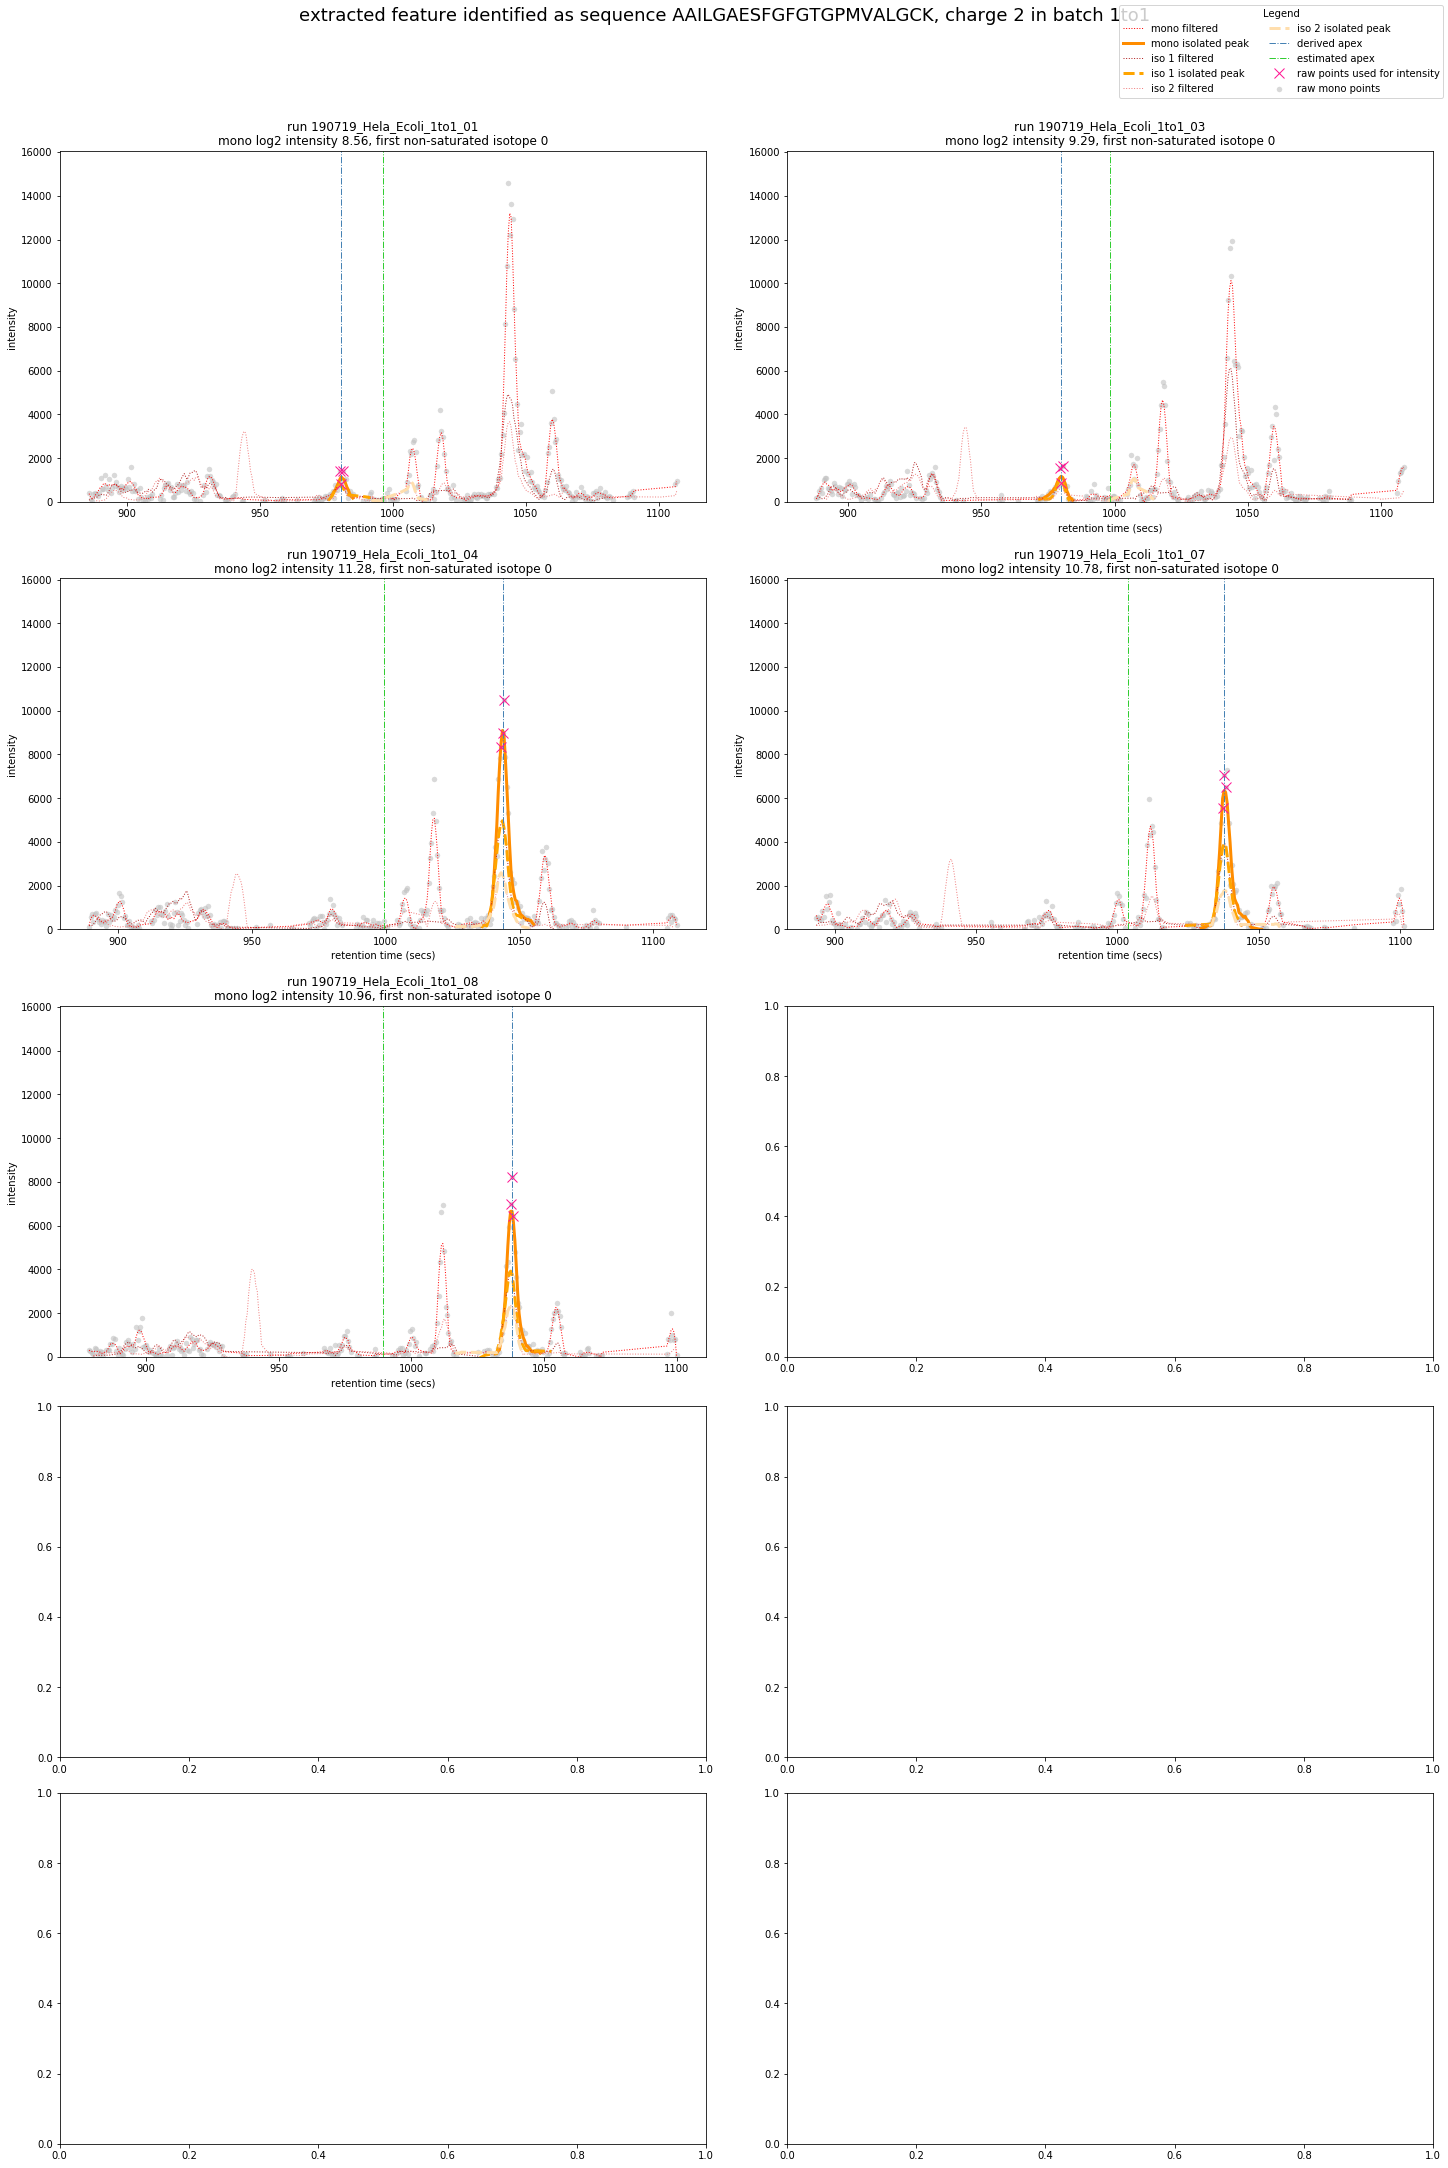

In [21]:
selected_batch = '1to1'

f, axarr = plt.subplots(nrows=5, ncols=2, constrained_layout=True)
f.set_figheight(30)
f.set_figwidth(20)
f.suptitle('extracted feature identified as sequence {}, charge {} in batch {}\n\n\n\n'.format(selected_sequence, selected_sequence_charge, selected_batch), fontsize=18)

max_labels = 0
for row_idx,row in enumerate(selected_sequence_df[selected_sequence_df.batch == selected_batch].itertuples()):
    r = int(row_idx / 2)
    c = row_idx % 2
    
    ax = axarr[r,c]  # row, column
    ax.set_title('run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(row.run_name, round(row.log_intensity,2), int(row.isotope_idx_not_in_saturation)))

    mono_raw_points_df = pd.DataFrame(json.loads(row.mono_raw_points_l), columns=['retention_time_secs','intensity'])
    mono_filtered_points_df = pd.DataFrame(json.loads(row.mono_filtered_points_l))
    isotope_1_filtered_points_df = pd.DataFrame(json.loads(row.isotope_1_filtered_points_l))
    isotope_2_filtered_points_df = pd.DataFrame(json.loads(row.isotope_2_filtered_points_l))    

    mono_rt_lower,mono_rt_upper = json.loads(row.mono_rt_bounds)
    mono_isolated_peak_df = mono_filtered_points_df[(mono_filtered_points_df.x >= mono_rt_lower) & (mono_filtered_points_df.x <= mono_rt_upper)]
    mono_rt_apex_derived = row.rt_apex
    estimated_rt_apex = json.loads(row.target_coords)['rt_apex']
    
    isotope_1_rt_lower,isotope_1_rt_upper = json.loads(row.isotope_1_rt_bounds)
    isotope_1_isolated_peak_df = isotope_1_filtered_points_df[(isotope_1_filtered_points_df.x >= isotope_1_rt_lower) & (isotope_1_filtered_points_df.x <= isotope_1_rt_upper)]
    
    isotope_2_rt_lower,isotope_2_rt_upper = json.loads(row.isotope_2_rt_bounds)
    isotope_2_isolated_peak_df = isotope_2_filtered_points_df[(isotope_2_filtered_points_df.x >= isotope_2_rt_lower) & (isotope_2_filtered_points_df.x <= isotope_2_rt_upper)]

    ax.scatter(mono_raw_points_df.retention_time_secs, mono_raw_points_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')

    # isotope 0
    ax.plot(mono_filtered_points_df.x, mono_filtered_points_df.filtered_intensity, marker='', color='red', linestyle=':', linewidth=1, ms=5, label='mono filtered')
    ax.plot(mono_isolated_peak_df.x, mono_isolated_peak_df.filtered_intensity, marker='', color='darkorange', linestyle='-', linewidth=3, ms=5, label='mono isolated peak')

    # isotope 1
    ax.plot(isotope_1_filtered_points_df.x, isotope_1_filtered_points_df.filtered_intensity, marker='', color='firebrick', linestyle=':', linewidth=1, ms=5, label='iso 1 filtered')
    ax.plot(isotope_1_isolated_peak_df.x, isotope_1_isolated_peak_df.filtered_intensity, marker='', color='orange', linestyle='--', linewidth=3, ms=5, label='iso 1 isolated peak')

    # isotope 2
    ax.plot(isotope_2_filtered_points_df.x, isotope_2_filtered_points_df.filtered_intensity, marker='', color='lightcoral', linestyle=':', linewidth=1, ms=5, label='iso 2 filtered')
    ax.plot(isotope_2_isolated_peak_df.x, isotope_2_isolated_peak_df.filtered_intensity, marker='', color='navajowhite', linestyle='--', linewidth=3, ms=5, label='iso 2 isolated peak')

    # apexes
    ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
    ax.axvline(estimated_rt_apex, color='limegreen', lw=1.0, ls='-.', label='estimated apex')
    if len(sequence_source_attribs_df[(sequence_source_attribs_df.file_idx == row.file_idx)]) > 0:
        sequence_source_rt = sequence_source_attribs_df[(sequence_source_attribs_df.file_idx == row.file_idx)].iloc[0].run_rt
        ax.axvline(sequence_source_rt, color='firebrick', lw=1.0, ls='-.', label='ground truth apex')

    # highlight the points used to calculate intensity
    frame_maximums_l = []
    for rt,group_df in mono_raw_points_df.groupby('retention_time_secs'):
        frame_maximums_l.append(group_df.loc[group_df.intensity.idxmax()])
    frame_maximums_df = pd.DataFrame(frame_maximums_l)
    frame_maximums_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
    frame_maximums_df.reset_index(drop=True, inplace=True)
    frame_maximums_df['rt_delta'] = np.abs(frame_maximums_df.retention_time_secs - mono_rt_apex_derived)
    apex_idx = frame_maximums_df.rt_delta.idxmin()
    apex_idx_minus_one = max(0, apex_idx-1)
    apex_idx_plus_one = min(len(frame_maximums_df)-1, apex_idx+1)
    summed_intensity = frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].intensity.sum()
    ax.plot(frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].retention_time_secs, frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].intensity, marker='x', color='deeppink', linestyle='', linewidth=1, ms=10, label='raw points used for intensity')
        
    # set up axes
    ax.set_ylim((0,sequence_intensity_max*1.1))
    ax.set_xlabel('retention time (secs)')
    ax.set_ylabel('intensity')
    
    # make a legend from all possible labels
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > max_labels:
        max_labels = len(labels)
        superset_handles = handles
        superset_labels = labels

f.legend(superset_handles, superset_labels, loc='upper right', ncol=2, title="Legend", fancybox=True)

plt.show()

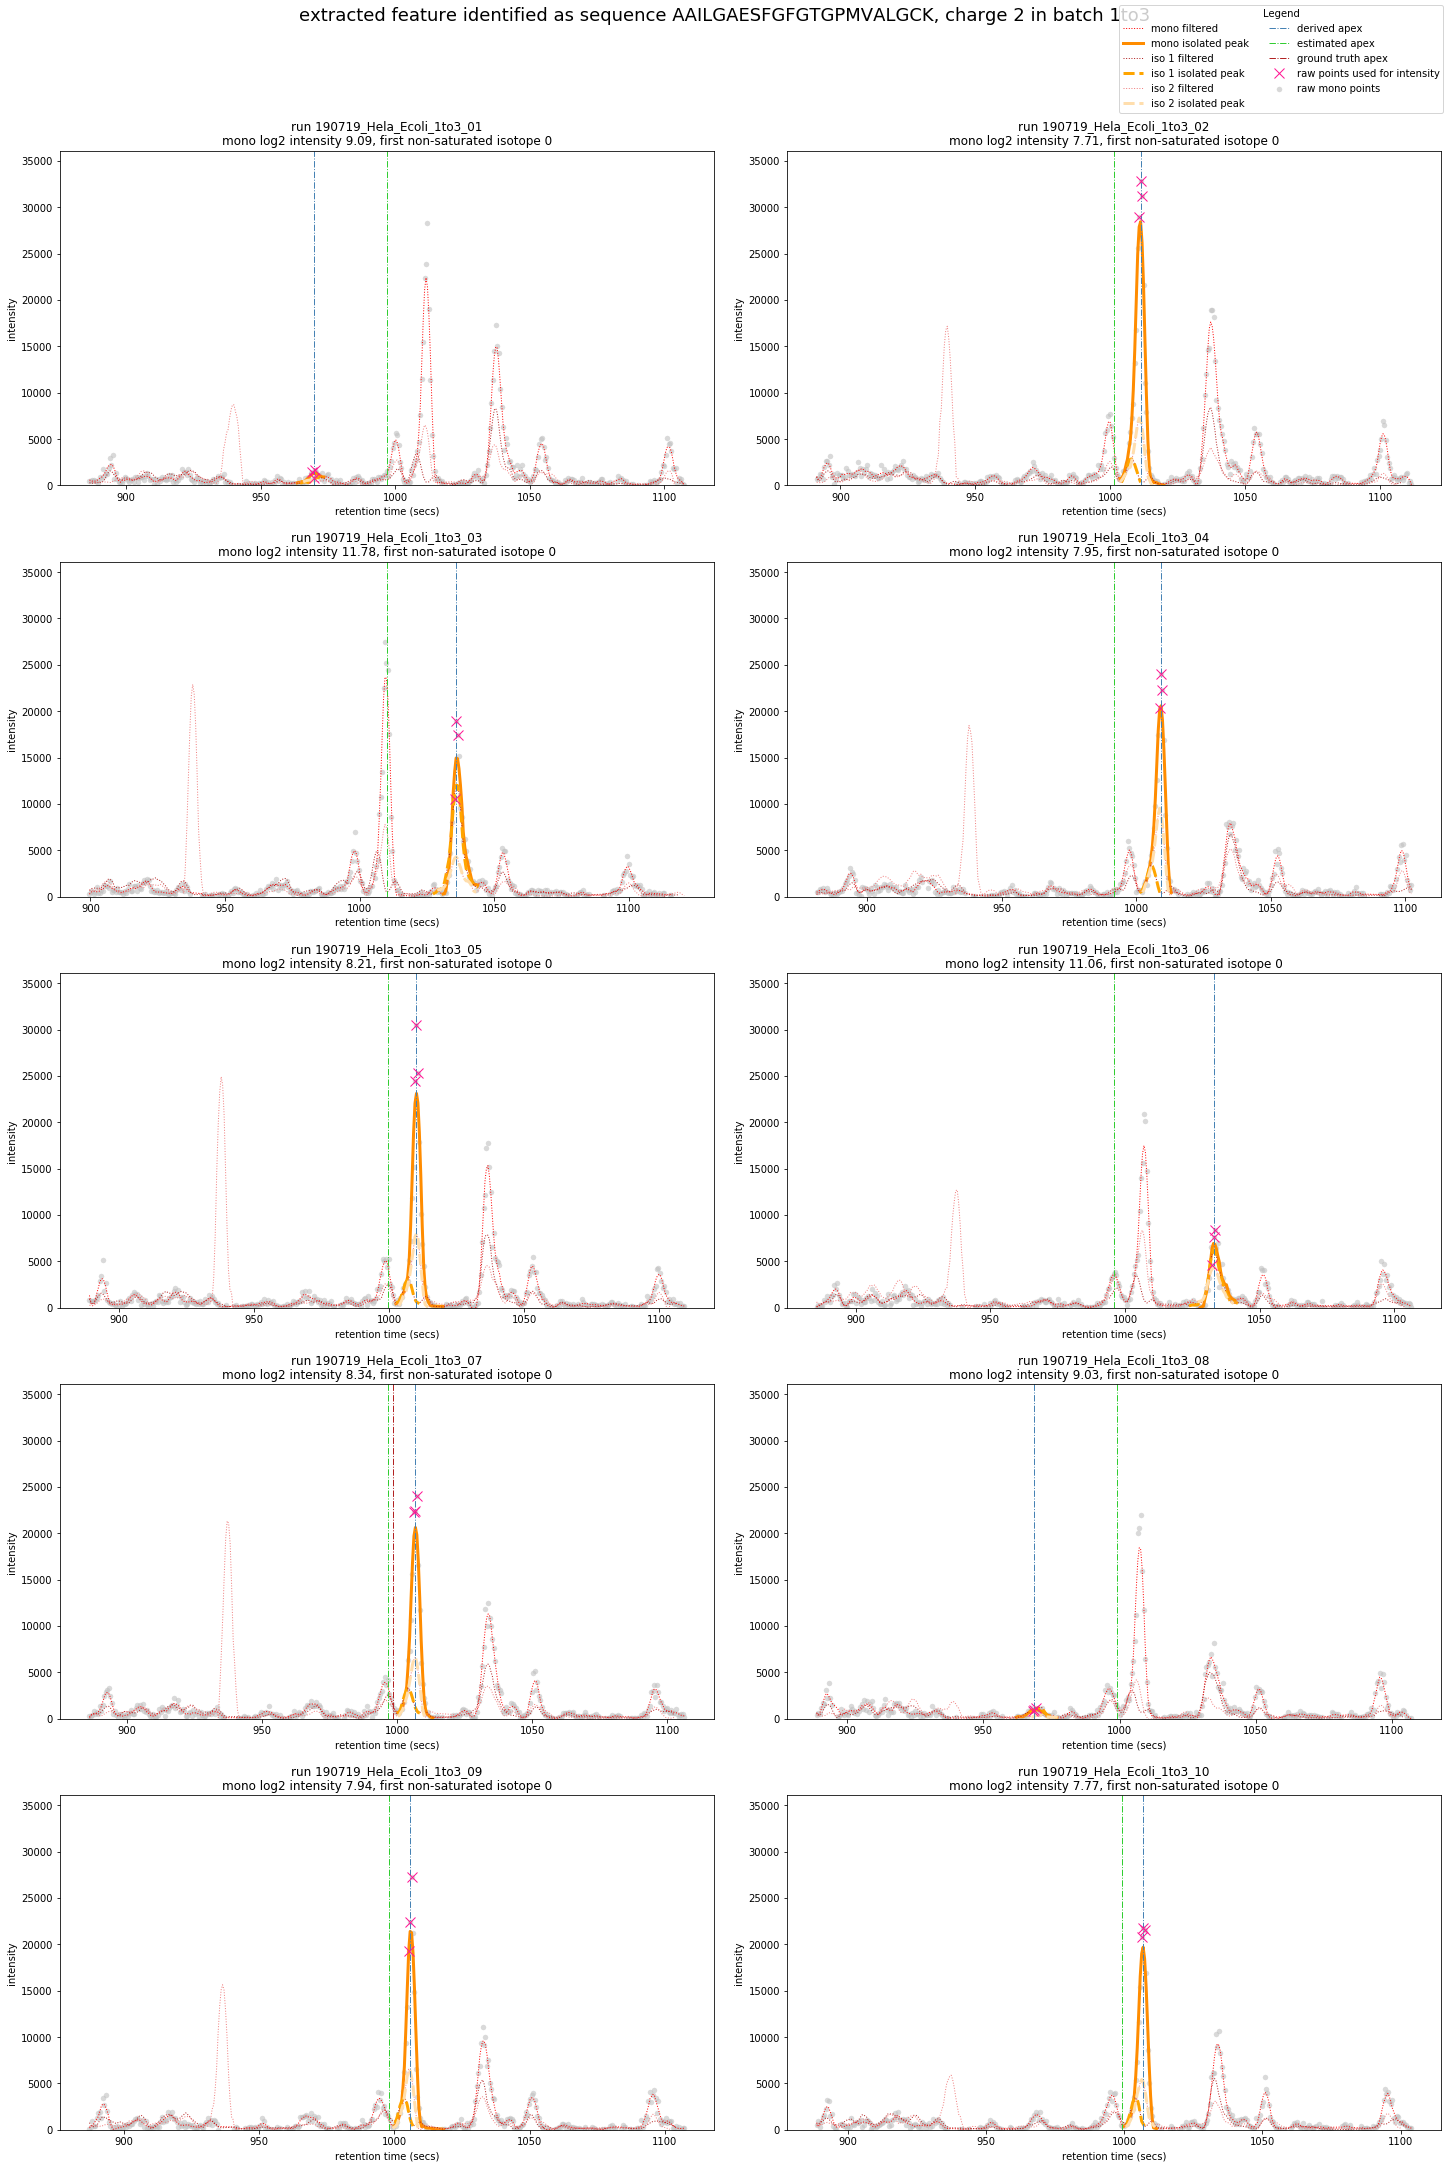

In [129]:
selected_batch = '1to3'

f, axarr = plt.subplots(nrows=5, ncols=2, constrained_layout=True)
f.set_figheight(30)
f.set_figwidth(20)
f.suptitle('extracted feature identified as sequence {}, charge {} in batch {}\n\n\n\n'.format(selected_sequence, selected_sequence_charge, selected_batch), fontsize=18)

max_labels = 0
for row_idx,row in enumerate(selected_sequence_df[selected_sequence_df.batch == selected_batch].itertuples()):
    r = int(row_idx / 2)
    c = row_idx % 2
    
    ax = axarr[r,c]  # row, column
    ax.set_title('run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(row.run_name, round(row.log_intensity,2), int(row.isotope_idx_not_in_saturation)))

    mono_raw_points_df = pd.DataFrame(json.loads(row.mono_raw_points_l), columns=['retention_time_secs','intensity'])
    mono_filtered_points_df = pd.DataFrame(json.loads(row.mono_filtered_points_l))
    isotope_1_filtered_points_df = pd.DataFrame(json.loads(row.isotope_1_filtered_points_l))
    isotope_2_filtered_points_df = pd.DataFrame(json.loads(row.isotope_2_filtered_points_l))    

    mono_rt_lower,mono_rt_upper = json.loads(row.mono_rt_bounds)
    mono_isolated_peak_df = mono_filtered_points_df[(mono_filtered_points_df.x >= mono_rt_lower) & (mono_filtered_points_df.x <= mono_rt_upper)]
    mono_rt_apex_derived = row.rt_apex
    estimated_rt_apex = json.loads(row.target_coords)['rt_apex']
    
    isotope_1_rt_lower,isotope_1_rt_upper = json.loads(row.isotope_1_rt_bounds)
    isotope_1_isolated_peak_df = isotope_1_filtered_points_df[(isotope_1_filtered_points_df.x >= isotope_1_rt_lower) & (isotope_1_filtered_points_df.x <= isotope_1_rt_upper)]
    
    isotope_2_rt_lower,isotope_2_rt_upper = json.loads(row.isotope_2_rt_bounds)
    isotope_2_isolated_peak_df = isotope_2_filtered_points_df[(isotope_2_filtered_points_df.x >= isotope_2_rt_lower) & (isotope_2_filtered_points_df.x <= isotope_2_rt_upper)]

    ax.scatter(mono_raw_points_df.retention_time_secs, mono_raw_points_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')

    # isotope 0
    ax.plot(mono_filtered_points_df.x, mono_filtered_points_df.filtered_intensity, marker='', color='red', linestyle=':', linewidth=1, ms=5, label='mono filtered')
    ax.plot(mono_isolated_peak_df.x, mono_isolated_peak_df.filtered_intensity, marker='', color='darkorange', linestyle='-', linewidth=3, ms=5, label='mono isolated peak')

    # isotope 1
    ax.plot(isotope_1_filtered_points_df.x, isotope_1_filtered_points_df.filtered_intensity, marker='', color='firebrick', linestyle=':', linewidth=1, ms=5, label='iso 1 filtered')
    ax.plot(isotope_1_isolated_peak_df.x, isotope_1_isolated_peak_df.filtered_intensity, marker='', color='orange', linestyle='--', linewidth=3, ms=5, label='iso 1 isolated peak')

    # isotope 2
    ax.plot(isotope_2_filtered_points_df.x, isotope_2_filtered_points_df.filtered_intensity, marker='', color='lightcoral', linestyle=':', linewidth=1, ms=5, label='iso 2 filtered')
    ax.plot(isotope_2_isolated_peak_df.x, isotope_2_isolated_peak_df.filtered_intensity, marker='', color='navajowhite', linestyle='--', linewidth=3, ms=5, label='iso 2 isolated peak')

    # apexes
    ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
    ax.axvline(estimated_rt_apex, color='limegreen', lw=1.0, ls='-.', label='estimated apex')
    if len(sequence_source_attribs_df[(sequence_source_attribs_df.file_idx == row.file_idx)]) > 0:
        sequence_source_rt = sequence_source_attribs_df[(sequence_source_attribs_df.file_idx == row.file_idx)].iloc[0].run_rt
        ax.axvline(sequence_source_rt, color='firebrick', lw=1.0, ls='-.', label='ground truth apex')

    # highlight the points used to calculate intensity
    frame_maximums_l = []
    for rt,group_df in mono_raw_points_df.groupby('retention_time_secs'):
        frame_maximums_l.append(group_df.loc[group_df.intensity.idxmax()])
    frame_maximums_df = pd.DataFrame(frame_maximums_l)
    frame_maximums_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
    frame_maximums_df.reset_index(drop=True, inplace=True)
    frame_maximums_df['rt_delta'] = np.abs(frame_maximums_df.retention_time_secs - mono_rt_apex_derived)
    apex_idx = frame_maximums_df.rt_delta.idxmin()
    apex_idx_minus_one = max(0, apex_idx-1)
    apex_idx_plus_one = min(len(frame_maximums_df)-1, apex_idx+1)
    summed_intensity = frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].intensity.sum()
    ax.plot(frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].retention_time_secs, frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].intensity, marker='x', color='deeppink', linestyle='', linewidth=1, ms=10, label='raw points used for intensity')
        
    # set up axes
    ax.set_ylim((0,sequence_intensity_max*1.1))
    ax.set_xlabel('retention time (secs)')
    ax.set_ylabel('intensity')
    
    # make a legend from all possible labels
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > max_labels:
        max_labels = len(labels)
        superset_handles = handles
        superset_labels = labels

f.legend(superset_handles, superset_labels, loc='upper right', ncol=2, title="Legend", fancybox=True)

plt.show()

#### look at how the intensity was calculated

In [150]:
monoisotope_intensities_l = json.loads(selected_sequence_s.isotope_intensities_l)[0]

In [151]:
summed_intensity = monoisotope_intensities_l[0]
inferred_intensity = monoisotope_intensities_l[2]
isotope_points_l = monoisotope_intensities_l[4]    # these are the raw points trimmed for the isotope - they are not the flattened points
isotope_apex_points = monoisotope_intensities_l[5]

In [152]:
isotope_df = pd.DataFrame(isotope_points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])

In [153]:
mono_rt_apex_derived = selected_sequence_s.rt_apex
mono_rt_apex_derived

821.8053712456003

In [154]:
isotope_apex_df = pd.DataFrame(isotope_apex_points, columns=['mz','scan','frame_id','retention_time_secs','intensity'])


#### calculate intensity for this monoisotope using the 'apex-max' method

In [155]:
isotope_df['rt_delta'] = np.abs(isotope_df.retention_time_secs - mono_rt_apex_derived)
isotope_df.sort_values(by=['rt_delta','intensity'], ascending=[True,False], inplace=True)
isotope_df.reset_index(drop=True, inplace=True)
summed_intensity = isotope_df.loc[:2].intensity.sum()
summed_intensity

6275.0

In [156]:
isotope_apex_df = isotope_df.loc[:2]

In [157]:
isotope_apex_df

,mz,scan,frame_id,retention_time_secs,intensity,rt_delta
0,758.402594,535.0,7656.0,821.805371,2172.0,0.0
1,758.402594,532.0,7656.0,821.805371,2133.0,0.0
2,758.402594,538.0,7656.0,821.805371,1970.0,0.0


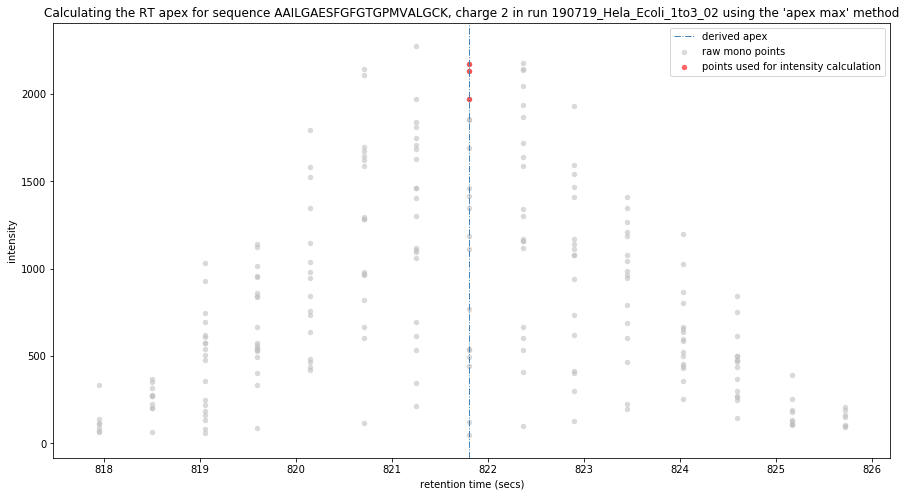

In [158]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Calculating the RT apex for sequence {}, charge {} in run {} using the \'apex max\' method'.format(selected_sequence, selected_sequence_charge, run_name)
plt.title(title)

ax.scatter(isotope_df.retention_time_secs, isotope_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')
ax.scatter(isotope_apex_df.retention_time_secs, isotope_apex_df.intensity, marker='o', color='red', lw=0, s=30, alpha=0.6, label='points used for intensity calculation')

ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
# ax.axvline(mono_rt_apex_estimated, color='limegreen', lw=1.0, ls='-.', label='estimated apex')

plt.legend(loc='best')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')

plt.show()

#### calculate intensity for this monoisotope using the 'frame' method

In [159]:
# find the intensity by summing the maximum point in the frame closest to the RT apex, and the frame maximums either side
frame_maximums_l = []
for frame_id,group_df in isotope_df.groupby('frame_id'):
    frame_maximums_l.append(group_df.loc[group_df.intensity.idxmax()])
frame_maximums_df = pd.DataFrame(frame_maximums_l)
frame_maximums_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
frame_maximums_df.reset_index(drop=True, inplace=True)
# find the index closest to the RT apex and the index either side
if (mono_rt_apex_derived is not None):
    frame_maximums_df['rt_delta'] = np.abs(frame_maximums_df.retention_time_secs - mono_rt_apex_derived)
    apex_idx = frame_maximums_df.rt_delta.idxmin()
else:
    apex_idx = frame_maximums_df.intensity.idxmax()
apex_idx_minus_one = max(0, apex_idx-1)
apex_idx_plus_one = min(len(frame_maximums_df)-1, apex_idx+1)
# sum the maximum intensity and the max intensity of the frame either side in RT
summed_intensity = frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].intensity.sum()
summed_intensity

6622.0

In [160]:
isotope_apex_df = frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one]

In [161]:
isotope_apex_df

,mz,scan,frame_id,retention_time_secs,intensity,rt_delta
6,758.402594,535.0,7651.0,821.253531,2274.0,0.551840
7,758.402594,535.0,7656.0,821.805371,2172.0,0.000000
8,758.402594,538.0,7661.0,822.363715,2176.0,0.558343


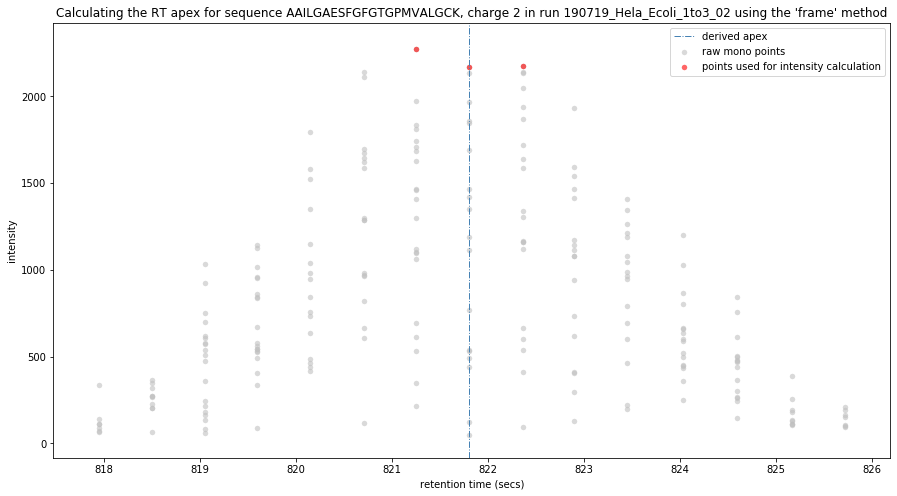

In [162]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Calculating the RT apex for sequence {}, charge {} in run {} using the \'frame\' method'.format(selected_sequence, selected_sequence_charge, run_name)
plt.title(title)

ax.scatter(isotope_df.retention_time_secs, isotope_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')
ax.scatter(isotope_apex_df.retention_time_secs, isotope_apex_df.intensity, marker='o', color='red', lw=0, s=30, alpha=0.6, label='points used for intensity calculation')

ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
# ax.axvline(mono_rt_apex_estimated, color='limegreen', lw=1.0, ls='-.', label='estimated apex')

plt.legend(loc='best')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')

plt.show()

#### calculate intensity for this monoisotope using the 'filtered apex' method

In [163]:
# find the intensity by summing the maximum point in the frame closest to the RT apex, and the frame maximums either side
mono_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.mono_filtered_points_l))


In [164]:
# find the index closest to the RT apex and the index either side
if (mono_rt_apex_derived is not None):
    mono_filtered_points_df['rt_delta'] = np.abs(mono_filtered_points_df.x - mono_rt_apex_derived)
    apex_idx = mono_filtered_points_df.rt_delta.idxmin()
else:
    apex_idx = mono_filtered_points_df.filtered_intensity.idxmax()
apex_idx_minus_one = max(0, apex_idx-1)
apex_idx_plus_one = min(len(mono_filtered_points_df)-1, apex_idx+1)
# sum the maximum intensity and the max intensity of the frame either side in RT
summed_intensity = mono_filtered_points_df.loc[apex_idx_minus_one:apex_idx_plus_one].filtered_intensity.sum()
summed_intensity

80382.58741258767

In [165]:
isotope_apex_df = mono_filtered_points_df.loc[apex_idx_minus_one:apex_idx_plus_one]

In [166]:
isotope_apex_df

,filtered_intensity,x,rt_delta
35,27008.582751,821.253531,0.551840
36,27419.314685,821.805371,0.000000
37,25954.689977,822.363715,0.558343


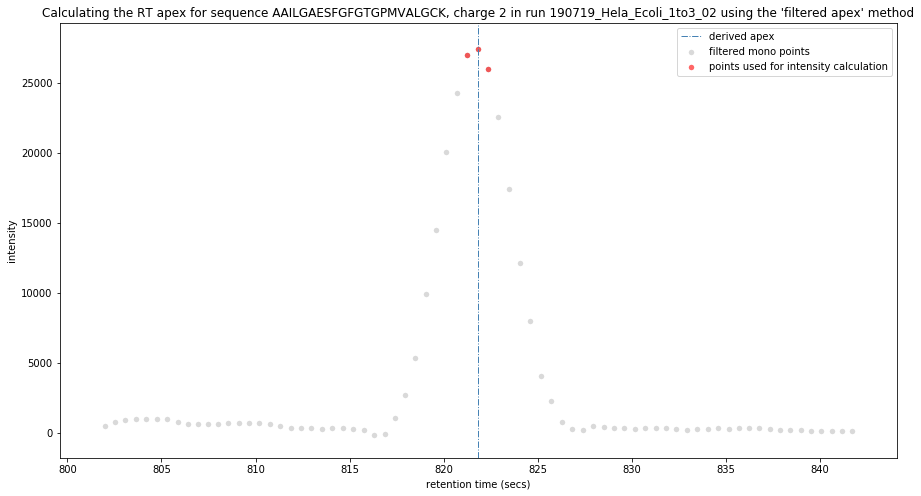

In [167]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Calculating the RT apex for sequence {}, charge {} in run {} using the \'filtered apex\' method'.format(selected_sequence, selected_sequence_charge, run_name)
plt.title(title)

ax.scatter(mono_filtered_points_df.x, mono_filtered_points_df.filtered_intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='filtered mono points')
ax.scatter(isotope_apex_df.x, isotope_apex_df.filtered_intensity, marker='o', color='red', lw=0, s=30, alpha=0.6, label='points used for intensity calculation')

ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
# ax.axvline(mono_rt_apex_estimated, color='limegreen', lw=1.0, ls='-.', label='estimated apex')

plt.legend(loc='best')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')

plt.show()